<a href="https://colab.research.google.com/github/beaten-by-the-market/krxnewsscrap/blob/main/krxvsnxt_cumul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 파이썬 세팅하고 조회일자 입력하기

In [1]:
#-----------------------------------------------------------
#필요한 패키지 import
#-----------------------------------------------------------
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from matplotlib import font_manager, rc
import numpy as np
from datetime import datetime
from time import sleep
from tqdm.notebook import tqdm

print('파이썬 실행을 위한 패키지 설치중입니다. 20초정도 소요됩니다.')

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# Matplotlib 폰트 캐시 삭제
font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
font_manager._load_fontmanager(try_read_cache=False)

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 조회할 날짜 선택하기
print('조회할 날짜를 YYYYMMDD 형태로 입력하고 엔터키를 치세요 (ex. 20250304)')
input_date = input()
# 날짜를 '오늘'로 지정하려면 : input_date = datetime.today().strftime('%Y%m%d')

파이썬 실행을 위한 패키지 설치중입니다. 20초정도 소요됩니다.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 125044 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-

## NXT, KRX 데이터를 공개된 각사 홈페이지에서 조회하여 복사해오기

In [2]:
#-----------------------------------------------------------
#거래일 식별하기(11003 코스피 지수 시세에서 날짜를 추출하는 방식)
#-----------------------------------------------------------

#[12001] 전종목 시세
#거래소 홈페이지에서 불러오기
gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp = {
  "locale": "ko_KR",
  "tboxindIdx_finder_equidx0_0": "코스피",
  "indIdx": "1",
  "indIdx2": "001",
  "codeNmindIdx_finder_equidx0_0": "코스피",
  "param1indIdx_finder_equidx0_0": "",
  "strtDd": "20250304", # 넥스트레이드 영업개시일
  "endDd": input_date,
  "share": "2",
  "money": "3",
  "csvxls_isNo": "false",
  "name": "fileDown",
  "url" : "dbms/MDC/STAT/standard/MDCSTAT00301"
}
headers = {'Referer' : 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201',
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

otp = requests.post(gen_otp_url, gen_otp, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_trdays = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')

# 조회할 날짜 리스트 생성
lookup_dates = df_trdays['일자'].str.replace('/', '').tolist()

# 잠시 쉬기
sleep(0.5)

# 수집할 데이터프레임 생성
df_cumul = pd.DataFrame()

# 순회하면서 수집
for loop_date in tqdm(lookup_dates, desc="NXT와 KRX의 대외공개된 홈페이지에서 데이터 수집중"):
  try:
    #-----------------------------------------------------------
    #데이터 불러오기(NXT와 KRX 모두)
    #-----------------------------------------------------------
    # 넥스트레이드
    url = 'https://www.nextrade.co.kr/brdinfoTime/brdinfoTimeList.do'

    params = {
        "_search": False,
        "nd": 1741120157913,
        "pageUnit": 900,
        "pageIndex": 1,
        "sidx": "",
        "sord": "asc",
        "scAggDd": loop_date,
        "scMktId": "",
        "searchKeyword": ""
    }

    # POST 요청
    response = requests.post(url, params=params)
    data = response.json()  # JSON 데이터 변환

    # 필요한 데이터 리스트 추출
    brdinfo_list = data.get("brdinfoTimeList", [])

    # 데이터프레임 전환
    df1 = pd.DataFrame(brdinfo_list)
    df_nxt = df1[['isuSrdCd', 'isuAbwdNm', 'mktNm', 'curPrc', 'contrastPrc', 'upDownRate', 'oppr', 'hgpr', 'lwpr', 'accTdQty', 'accTrval', 'tdhlYn']]

    # 데이터프레임으로 변환할 컬럼 정의
    df_nxt.columns = ['종목코드', '종목명', '시장구분', '현재가', '대비', '등락률', '시가', '고가', '저가', '거래량', '거래대금', '거래정지']

    #종목코드의 첫 앞의 A를 제거하기
    df_nxt = df_nxt.copy()  # 명시적으로 새로운 데이터프레임 생성
    df_nxt['종목코드'] = df_nxt['종목코드'].str.replace('A', '', regex=True)

    # 필요한 칼럼만 남기기
    df_nxt = df_nxt[['종목코드', '종목명', '시장구분', '현재가', '등락률', '거래량', '거래대금']]

    # 칼럼명 변경하기
    df_nxt = df_nxt.rename(columns={'현재가': 'NXT현재가', '등락률': 'NXT등락률', '거래량': 'NXT거래량', '거래대금':'NXT거래대금'})

    #-----------------------------------------------------------
    #정보데이터시스템에서 불러오는 과정
    #-----------------------------------------------------------

    #[12001] 전종목 시세
    #거래소 홈페이지에서 불러오기
    gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
    gen_otp = {
        'locale' : 'ko_KR',
        'mktId': 'ALL',
        'trdDd': loop_date,
        'share': '1',
        'money': '1',
        'csvxls_isNo': 'false',
        'name': 'fileDown',
        'url': 'dbms/MDC/STAT/standard/MDCSTAT01501'
        }

    headers = {'Referer' : 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201',
              'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    otp = requests.post(gen_otp_url, gen_otp, headers = headers).text

    down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
    down_content = requests.post(down_url, {'code': otp}, headers = headers)


    df_krx = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')
    df_krx['시장구분'] = df_krx['시장구분'].replace('KOSDAQ GLOBAL', 'KOSDAQ')
    df_krx = df_krx.rename(columns=({'단축코드':'stock_code'}))

    # 필요한 칼럼만 남기기
    df_krx = df_krx[['종목코드', '종가', '등락률', '거래량', '거래대금', '시가총액']]

    # 칼럼명 변경하기
    df_krx = df_krx.rename(columns={'종가': 'KRX종가','등락률': 'KRX종가등락률', '거래량': 'KRX거래량', '거래대금': 'KRX거래대금'})


    # 데이터 합치기
    df_agg = pd.merge(df_nxt, df_krx, on='종목코드', how='left')
    df_agg['거래량비중'] = 100*(df_agg['NXT거래량']/df_agg['KRX거래량'])
    df_agg['거래대금비중'] = 100*(df_agg['NXT거래대금']/df_agg['KRX거래대금'])

    # 넥스트레이드 기준 날짜 및 시각 출력
    if data.get("brdinfoTimeList"):
        now_date = data["setTime"]
        print(f"{now_date} 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.")
    else:
        print("데이터가 없습니다.")

    # 수집일 칼럼으로 추가하기
    df_agg['수집일'] = loop_date

    # 데이터프레임 출력
    df_agg = df_agg.copy()[['수집일', '시장구분', '종목코드', '종목명', '시가총액', 'NXT거래량', 'KRX거래량', '거래량비중', 'NXT거래대금','KRX거래대금','거래대금비중']]

    # 합치기
    df_cumul = pd.concat([df_cumul, df_agg], axis = 0)

    # 부하 방지를 위한 쉬어가기
    sleep(0.5)

  except:
    print(f'{loop_date} 날짜의 수집과정에서 에러 발생')
    pass

NXT와 KRX의 대외공개된 홈페이지에서 데이터 수집중:   0%|          | 0/10 [00:00<?, ?it/s]

2025-03-17 17:16 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-14 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-13 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-12 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-11 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-10 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-07 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-06 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-05 20:00 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-04 20:00 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.


## 취합하여 데이터프레임으로 만들고 표출하기

In [8]:
# 날짜별 데이터프레임 생성
df_bydate = df_cumul.groupby('수집일').agg({
    'NXT거래량': 'sum',
    'KRX거래량': 'sum',
    'NXT거래대금': 'sum',
    'KRX거래대금': 'sum'
}).reset_index()

# 당일거래량비중과 당일거래대금비중 계산
df_bydate['당일거래량비중'] = (df_bydate['NXT거래량'] / df_bydate['KRX거래량']) * 100
df_bydate['당일거래대금비중'] = (df_bydate['NXT거래대금'] / df_bydate['KRX거래대금']) * 100

# 종목별 데이터프레임 생성
df_bystock = df_cumul.groupby(['종목코드', '종목명', '시장구분']).agg({
    'NXT거래량': 'sum',
    'KRX거래량': 'sum',
    'NXT거래대금': 'sum',
    'KRX거래대금': 'sum',
    '시가총액': 'first'  # 각 종목의 첫 번째 시가총액 값 사용
}).reset_index()

# 기간거래량비중과 기간거래대금비중 계산
df_bystock['기간거래량비중'] = (df_bystock['NXT거래량'] / df_bystock['KRX거래량']) * 100
df_bystock['기간거래대금비중'] = (df_bystock['NXT거래대금'] / df_bystock['KRX거래대금']) * 100

# 거래량 비중 기준으로 정렬하기
df_bystock = df_bystock.copy().sort_values(by='기간거래량비중', ascending=False)

# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

def format_market_cap(value):
    if isinstance(value, (int, float)):
        return f"{value / 100000000:,.0f}"  # 억원 단위 변환 후 천 단위 콤마 추가
    return value

# 서식적용할 데이터프레임 복사
df_bydate_show = df_bydate.copy()
df_bystock_show = df_bystock.copy()

# 1. 거래량 칼럼에 format_number 적용
df_bydate_show[['NXT거래량', 'KRX거래량']] = df_bydate_show[['NXT거래량', 'KRX거래량']].map(format_number)
df_bystock_show[['NXT거래량', 'KRX거래량']] = df_bystock_show[['NXT거래량', 'KRX거래량']].map(format_number)

# 2. 거래대금과 시가총액 칼럼에 format_market_cap 적용 (억원 단위)
df_bydate_show[['NXT거래대금', 'KRX거래대금']] = df_bydate_show[['NXT거래대금', 'KRX거래대금']].map(format_market_cap)
df_bystock_show[['NXT거래대금', 'KRX거래대금', '시가총액']] = df_bystock_show[['NXT거래대금', 'KRX거래대금', '시가총액']].map(format_market_cap)

# 3. 비중 칼럼에 format_percentage 적용
df_bydate_show[['당일거래량비중', '당일거래대금비중']] = df_bydate_show[['당일거래량비중', '당일거래대금비중']].map(format_percentage)
df_bystock_show[['기간거래량비중', '기간거래대금비중']] = df_bystock_show[['기간거래량비중', '기간거래대금비중']].map(format_percentage)

# 칼럼명 수정
df_bystock_show = df_bystock_show.rename(columns={'시가총액': '시가총액(억원)', 'KRX거래대금':'KRX거래대금(억원)', 'NXT거래대금':'NXT거래대금(억원)'})
df_bydate_show = df_bydate_show.rename(columns={'시가총액': '시가총액(억원)', 'KRX거래대금':'KRX거래대금(억원)', 'NXT거래대금':'NXT거래대금(억원)'})

# 칼럼순서 수정
df_bydate_show = df_bydate_show[['수집일', '당일거래량비중','NXT거래량', 'KRX거래량', '당일거래대금비중', 'NXT거래대금(억원)', 'KRX거래대금(억원)']]
df_bystock_show = df_bystock_show[['종목코드', '종목명', '시장구분','시가총액(억원)','기간거래량비중', 'NXT거래량', 'KRX거래량', '기간거래대금비중', 'NXT거래대금(억원)', 'KRX거래대금(억원)']]

# 출력
period = df_bydate_show.수집일.min()+' ~ '+df_bydate_show.수집일.max()
print(f'\n\n{period} 기간동안 전체 종목의 거래량, 거래대금 합계 및 비중')
display(df_bydate_show)
print(f'\n\n{period} 기간동안 종목별 거래량, 거래대금 합계 및 비중')
display(df_bystock_show)
# 데이터프레임을 엑셀 파일로 저장
df_bystock_show.to_excel('download.xlsx')
# 파일 다운로드를 위한 모듈 임포트
from google.colab import files
# 저장한 엑셀 파일 다운로드
files.download('download.xlsx')



20250304 ~ 20250317 기간동안 전체 종목의 거래량, 거래대금 합계 및 비중


,수집일,당일거래량비중,NXT거래량,KRX거래량,당일거래대금비중,NXT거래대금(억원),KRX거래대금(억원)
0,20250304,18.76,"434,890","2,318,056",29.33,202,689
1,20250305,41.89,"1,012,370","2,416,940",36.47,240,657
2,20250306,38.78,"665,408","1,715,929",35.22,172,489
3,20250307,40.93,"863,477","2,109,772",35.07,185,529
4,20250310,28.05,"594,423","2,119,180",24.66,209,849
5,20250311,17.98,"375,043","2,085,347",19.29,114,592
6,20250312,19.02,"356,418","1,873,834",20.80,99,477
7,20250313,13.81,"367,983","2,665,357",13.97,93,667
8,20250314,20.57,"311,704","1,515,259",21.07,83,395
9,20250317,24.19,"4,585,252","18,951,435",21.19,"1,243","5,863"




20250304 ~ 20250317 기간동안 종목별 거래량, 거래대금 합계 및 비중


,종목코드,종목명,시장구분,시가총액(억원),기간거래량비중,NXT거래량,KRX거래량,기간거래대금비중,NXT거래대금(억원),KRX거래대금(억원)
59,086450,동국제약,KOSDAQ,"6,700",81.49,"2,087,148","2,561,307",82.20,332,404
25,009520,포스코엠텍,KOSDAQ,"6,013",53.83,"340,853","633,227",54.19,51,94
68,108860,셀바스AI,KOSDAQ,"3,547",51.47,"86,451","167,955",51.66,11,22
47,058610,에스피지,KOSDAQ,"5,833",45.87,"70,932","154,625",45.89,19,41
24,008770,호텔신라,KOSPI,"15,425",41.42,"20,137","48,621",41.39,8,19
...,...,...,...,...,...,...,...,...,...,...
17,005830,DB손해보험,KOSPI,"67,402",4.58,"9,854","215,098",4.57,9,204
29,012750,에스원,KOSPI,"23,597",4.36,"1,301","29,858",4.36,1,18
10,002840,미원상사,KOSPI,"8,716",4.31,107,"2,484",4.29,0,5
40,039490,키움증권,KOSPI,"31,066",3.69,"2,147","58,126",3.69,3,70


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 시각화해서 보기(종목이 너무 많은 관계로, 종목별 표출은 NXT 비중이 전체거래량에서 상위인 30개 종목만 표출)

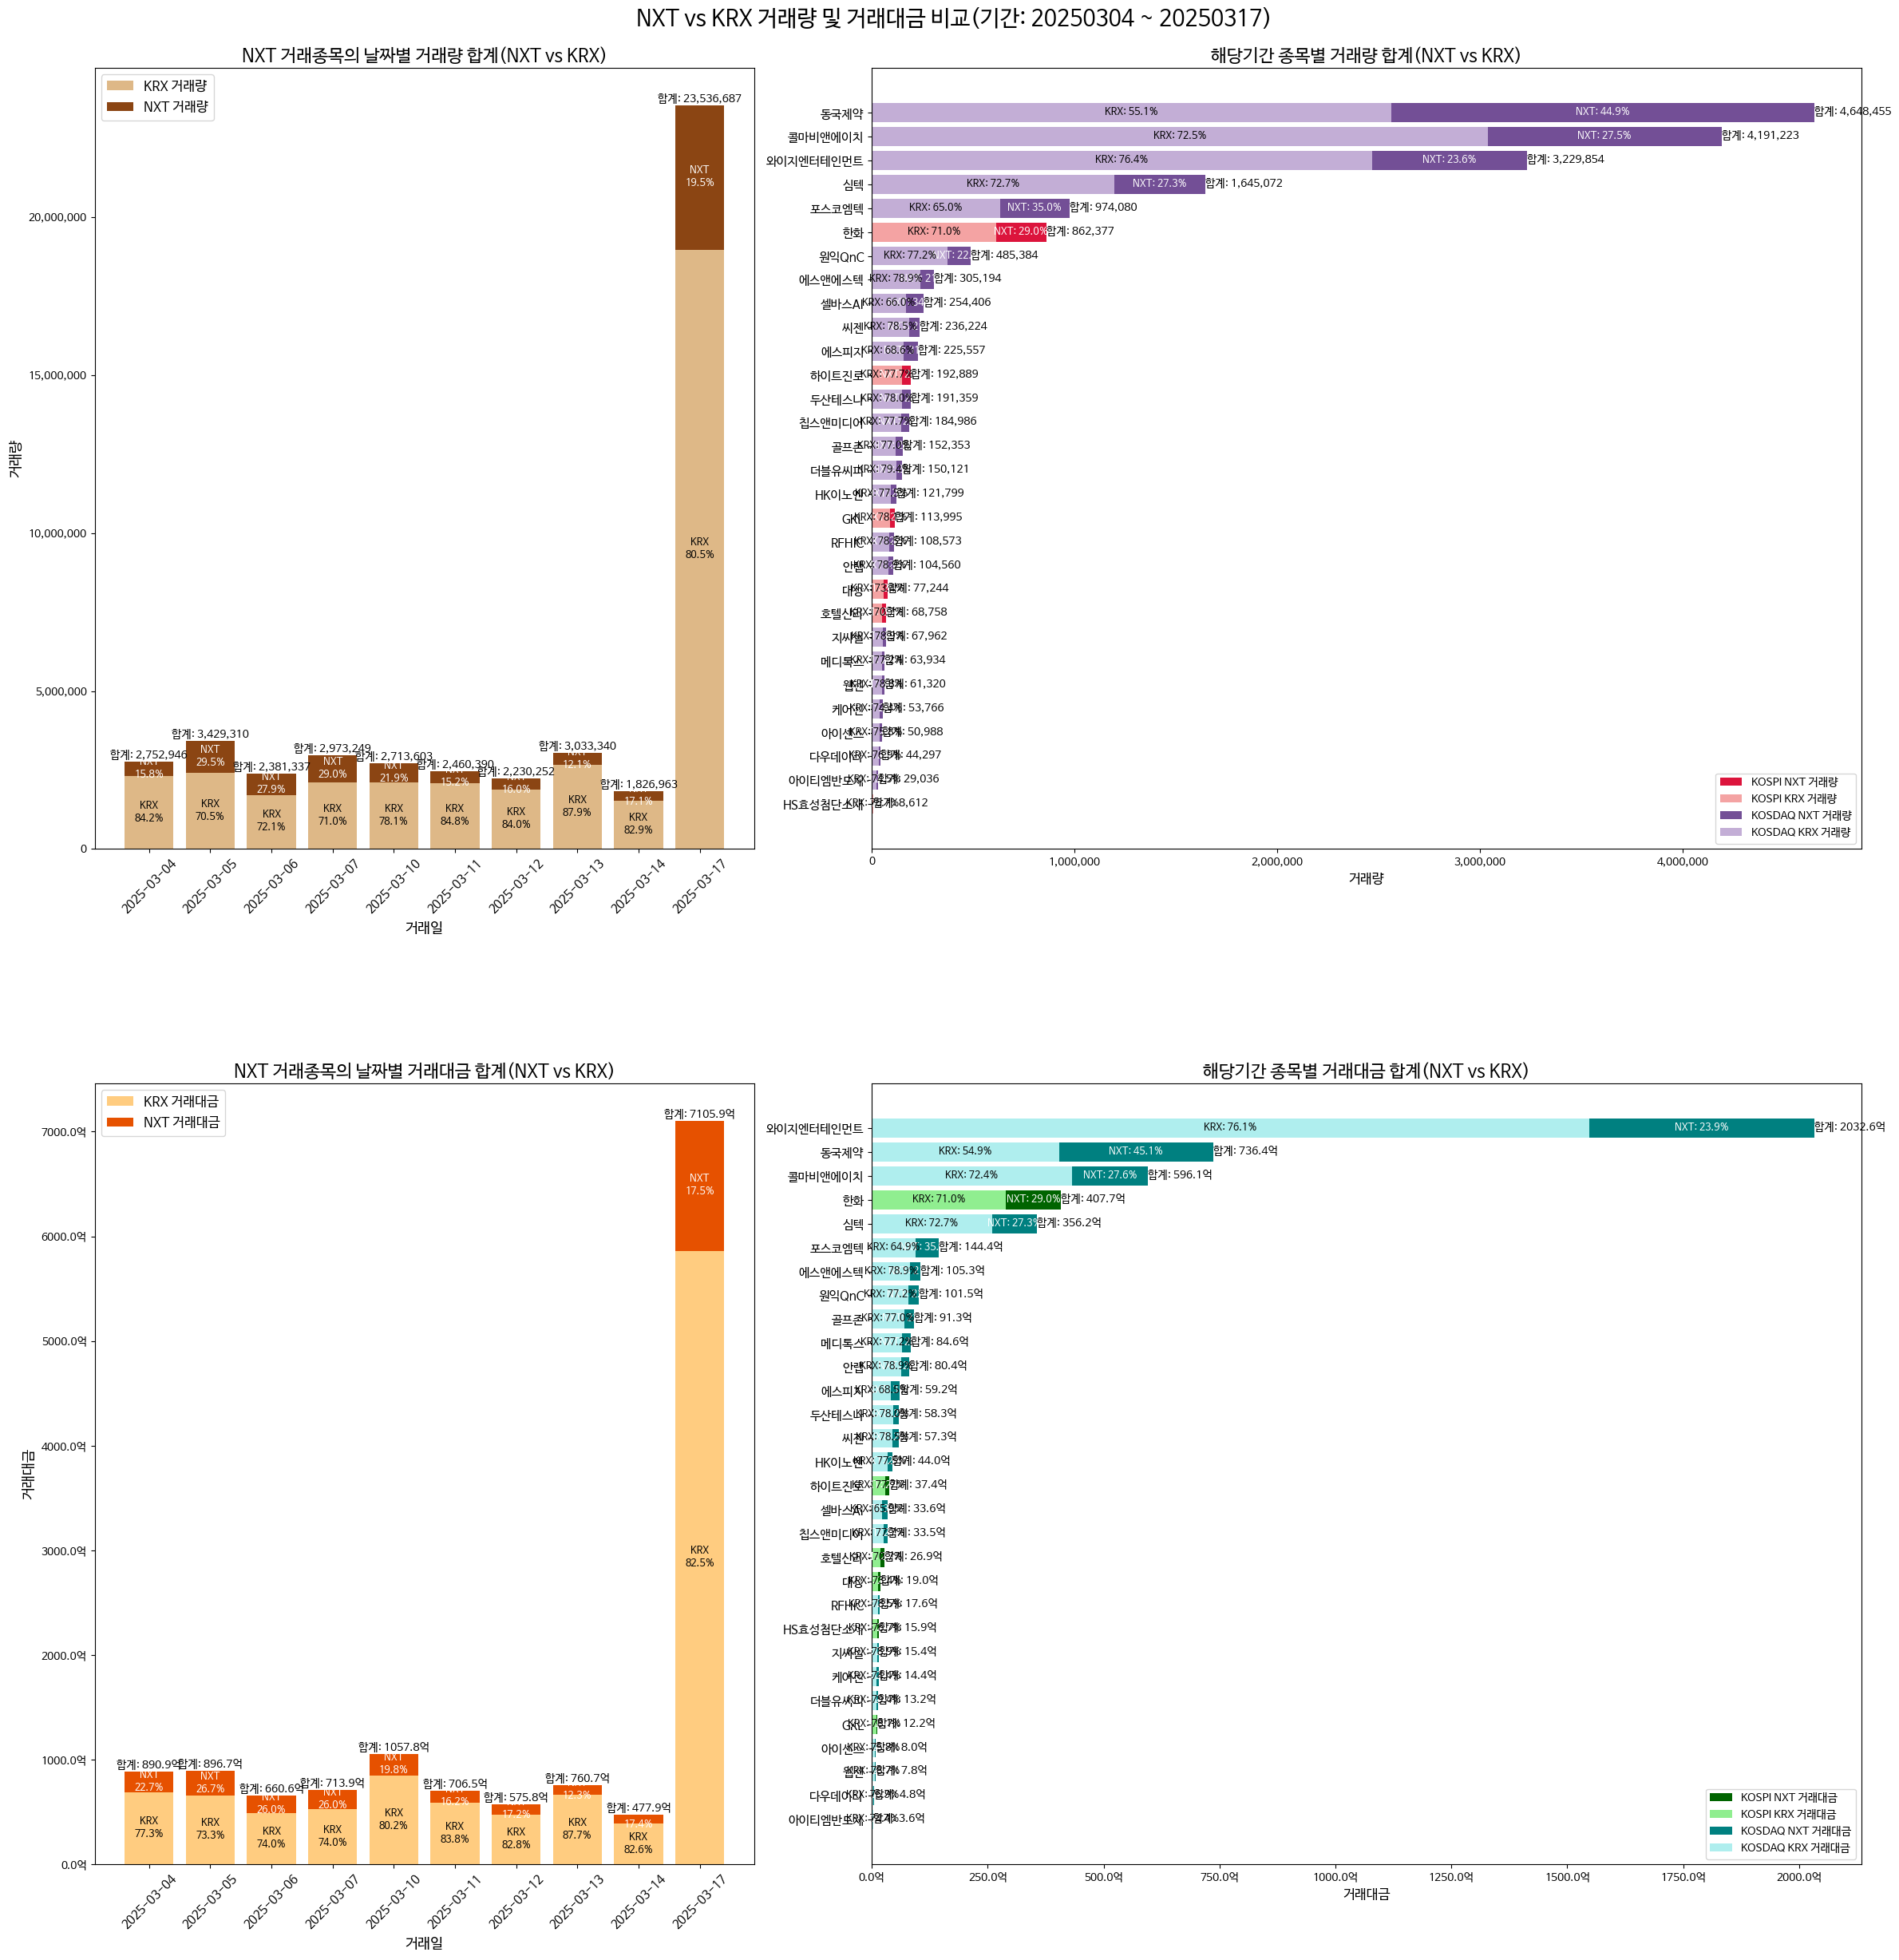

In [12]:
# 4개의 서브플롯을 포함하는 하나의 figure 생성
fig, axes = plt.subplots(2, 2, figsize=(24, 25), gridspec_kw={'width_ratios': [1, 1.5]})
ax1, ax2 = axes[0]  # 상단 (거래량)
ax3, ax4 = axes[1]  # 하단 (거래대금)

# ============= 좌상단 그래프: 날짜별 거래량 =============
# 날짜 형식 변환
df_bydate['수집일'] = pd.to_datetime(df_bydate['수집일'], format='%Y%m%d')

# 날짜 기준으로 정렬
df_bydate_sorted = df_bydate.sort_values('수집일')

# X축 위치 설정
x = np.arange(len(df_bydate_sorted))

# 스택 바 차트 데이터 준비 (거래량)
nxt_volumes = df_bydate_sorted['NXT거래량'].values
krx_volumes = df_bydate_sorted['KRX거래량'].values
total_volumes = nxt_volumes+krx_volumes

# 스택 바 차트 그리기
bars_krx = ax1.bar(x, krx_volumes, label='KRX 거래량', color='#DEB887')
bars_nxt = ax1.bar(x, nxt_volumes, bottom=krx_volumes, label='NXT 거래량', color='#8B4513')

# 데이터 레이블 추가 (백분율)
for i, (nxt, krx, total) in enumerate(zip(nxt_volumes, krx_volumes, total_volumes)):
    # 백분율 계산
    nxt_percent = (nxt / total) * 100
    krx_percent = (krx / total) * 100

    # NXT 레이블
    ax1.text(i, krx + nxt/2, f'NXT\n{nxt_percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # KRX 레이블
    ax1.text(i, krx/2, f'KRX\n{krx_percent:.1f}%', ha='center', va='center', fontsize=9)

    # 전체 합계 레이블
    ax1.text(i, total, f'합계: {int(total):,}', ha='center', va='bottom', fontsize=10)

# X축 및 Y축 레이블 설정
ax1.set_xlabel('거래일', fontsize=13)
ax1.set_ylabel('거래량', fontsize=13)
ax1.set_title('NXT 거래종목의 날짜별 거래량 합계(NXT vs KRX)', fontsize=16)

# X축 눈금 설정
ax1.set_xticks(x)
ax1.set_xticklabels(df_bydate_sorted['수집일'].dt.strftime('%Y-%m-%d'), fontsize=11, rotation=45)

# Y축 단위 설정 (천 단위 구분자)
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# 범례 추가
ax1.legend(fontsize=12)

# ============= 우상단 그래프: 종목별 거래량 =============
# 전체 거래대금 기준 내림차순 정렬
df_bystock['합계거래량'] = df_bystock['KRX거래량'] + df_bystock['NXT거래량']

# NXT 거래량 비율 계산
df_bystock['NXT거래량비율'] = (df_bystock['NXT거래량'] / df_bystock['합계거래량']) * 100

# NXT 거래량 비율이 높은 순으로 정렬하고 상위 40개만 선택
df_bystock_sorted_vol = df_bystock.sort_values(by='NXT거래량비율', ascending=False).head(30).sort_values(by='합계거래량', ascending=False)

# Y축 위치 설정
y = np.arange(len(df_bystock_sorted_vol))

# 스택 바 차트 데이터 준비
nxt_volumes = df_bystock_sorted_vol['NXT거래량'].values
krx_volumes = df_bystock_sorted_vol['KRX거래량'].values
total_volumes = nxt_volumes+krx_volumes

# 색상 지정
nxt_colors = np.where(df_bystock_sorted_vol['시장구분'] == 'KOSPI', 'crimson', '#734F96')
krx_colors = np.where(df_bystock_sorted_vol['시장구분'] == 'KOSPI', '#F4A3A3', '#C3AED6')

# 스택 가로 막대 그래프 그리기
bars_krx = ax2.barh(y, krx_volumes, label='KRX 거래량', color=krx_colors)
bars_nxt = ax2.barh(y, nxt_volumes, left=krx_volumes, label='NXT 거래량', color=nxt_colors)

# 데이터 레이블 추가 (백분율)
for i, (nxt, krx, total) in enumerate(zip(nxt_volumes, krx_volumes, total_volumes)):
    # 백분율 계산
    nxt_percent = (nxt / total) * 100
    krx_percent = (krx / total) * 100

    # NXT 레이블
    if nxt > total * 0.05:  # NXT 부분이 충분히 큰 경우에만 표시
        ax2.text(krx + nxt/2, i, f'NXT: {nxt_percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # KRX 레이블
    if krx > total * 0.05:  # KRX 부분이 충분히 큰 경우에만 표시
        ax2.text(krx/2, i, f'KRX: {krx_percent:.1f}%', ha='center', va='center', fontsize=9)

    # 전체 합계 레이블
    ax2.text(total, i, f'합계: {int(total):,}', ha='left', va='center', fontsize=10)

# Y축 레이블 설정
ax2.set_yticks(y)
ax2.set_yticklabels(df_bystock_sorted_vol['종목명'], fontsize=11)

# X축 및 Y축 레이블 설정
ax2.set_xlabel('거래량', fontsize=12)
ax2.set_title('해당기간 종목별 거래량 합계(NXT vs KRX)', fontsize=16)

# X축 단위 설정 (천 단위 구분자)
ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Y축 반전
ax2.invert_yaxis()

# 범례 추가
vol_leg_handles = [
    plt.Rectangle((0,0),1,1,fc="crimson", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#F4A3A3", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#734F96", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#C3AED6", edgecolor='none')
]

ax2.legend(vol_leg_handles,
           ['KOSPI NXT 거래량', 'KOSPI KRX 거래량',
            'KOSDAQ NXT 거래량', 'KOSDAQ KRX 거래량'],
           fontsize=10, loc='lower right')

# ============= 좌하단 그래프: 날짜별 거래대금 =============
# 스택 바 차트 데이터 준비 (거래대금)
nxt_values = df_bydate_sorted['NXT거래대금'].values
krx_values = df_bydate_sorted['KRX거래대금'].values
total_values = nxt_values+krx_values

# 스택 바 차트 그리기
bars_krx = ax3.bar(x, krx_values, label='KRX 거래대금', color='#FFCC80')  # 연한 주황색
bars_nxt = ax3.bar(x, nxt_values, bottom=krx_values, label='NXT 거래대금', color='#E65100')  # 짙은 주황색

# 데이터 레이블 추가 (백분율)
for i, (nxt, krx, total) in enumerate(zip(nxt_values, krx_values, total_values)):
    # 백분율 계산
    nxt_percent = (nxt / total) * 100
    krx_percent = (krx / total) * 100

    # NXT 레이블
    ax3.text(i, krx + nxt/2, f'NXT\n{nxt_percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # KRX 레이블
    ax3.text(i, krx/2, f'KRX\n{krx_percent:.1f}%', ha='center', va='center', fontsize=9)

    # 전체 합계 레이블 (억원)
    ax3.text(i, total, f'합계: {total/100000000:.1f}억', ha='center', va='bottom', fontsize=10)

# X축 및 Y축 레이블 설정
ax3.set_xlabel('거래일', fontsize=13)
ax3.set_ylabel('거래대금', fontsize=13)
ax3.set_title('NXT 거래종목의 날짜별 거래대금 합계(NXT vs KRX)', fontsize=16)

# X축 눈금 설정
ax3.set_xticks(x)
ax3.set_xticklabels(df_bydate_sorted['수집일'].dt.strftime('%Y-%m-%d'), fontsize=11, rotation=45)

# Y축 단위 설정 (억원)
ax3.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1f}억".format(x/100000000)))

# 범례 추가
ax3.legend(fontsize=12)

# ============= 우하단 그래프: 종목별 거래대금 =============
# 전체 거래대금 계산
df_bystock['합계거래대금'] = df_bystock['KRX거래대금'] + df_bystock['NXT거래대금']

# NXT 거래대금 비율 계산
df_bystock['NXT거래대금비율'] = (df_bystock['NXT거래대금'] / df_bystock['합계거래대금']) * 100

# NXT 거래대금 비율이 높은 순으로 정렬하고 상위 40개만 선택
df_bystock_sorted_val = df_bystock.sort_values(by='NXT거래대금비율', ascending=False).head(30).sort_values(by='합계거래대금', ascending=False)

# Y축 위치 설정
y = np.arange(len(df_bystock_sorted_val))

# 스택 바 차트 데이터 준비
nxt_values = df_bystock_sorted_val['NXT거래대금'].values
krx_values = df_bystock_sorted_val['KRX거래대금'].values
total_values = nxt_values+krx_values

# 색상 지정
nxt_colors = np.where(df_bystock_sorted_val['시장구분'] == 'KOSPI', '#006400', '#008080')  # 진한 녹색, 진한 청록색
krx_colors = np.where(df_bystock_sorted_val['시장구분'] == 'KOSPI', '#90EE90', '#AFEEEE')  # 연한 녹색, 연한 청록색

# 스택 가로 막대 그래프 그리기
bars_krx = ax4.barh(y, krx_values, label='KRX 거래대금', color=krx_colors)
bars_nxt = ax4.barh(y, nxt_values, left=krx_values, label='NXT 거래대금', color=nxt_colors)

# 데이터 레이블 추가 (백분율)
for i, (nxt, krx, total) in enumerate(zip(nxt_values, krx_values, total_values)):
    # 백분율 계산
    nxt_percent = (nxt / total) * 100
    krx_percent = (krx / total) * 100

    # NXT 레이블
    if nxt > total * 0.05:  # NXT 부분이 충분히 큰 경우에만 표시
        ax4.text(krx + nxt/2, i, f'NXT: {nxt_percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # KRX 레이블
    if krx > total * 0.05:  # KRX 부분이 충분히 큰 경우에만 표시
        ax4.text(krx/2, i, f'KRX: {krx_percent:.1f}%', ha='center', va='center', fontsize=9)

    # 전체 합계 레이블 (억원)
    ax4.text(total, i, f'합계: {total/100000000:.1f}억', ha='left', va='center', fontsize=10)

# Y축 레이블 설정
ax4.set_yticks(y)
ax4.set_yticklabels(df_bystock_sorted_val['종목명'], fontsize=11)

# X축 및 Y축 레이블 설정
ax4.set_xlabel('거래대금', fontsize=12)
ax4.set_title('해당기간 종목별 거래대금 합계(NXT vs KRX)', fontsize=16)

# X축 단위 설정 (억원)
ax4.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1f}억".format(x/100000000)))

# Y축 반전
ax4.invert_yaxis()

# 범례 추가
val_leg_handles = [
    plt.Rectangle((0,0),1,1,fc="#006400", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#90EE90", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#008080", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#AFEEEE", edgecolor='none')
]

ax4.legend(val_leg_handles,
           ['KOSPI NXT 거래대금', 'KOSPI KRX 거래대금',
            'KOSDAQ NXT 거래대금', 'KOSDAQ KRX 거래대금'],
           fontsize=10, loc='lower right')

# 전체 그림 제목 (상단에 표시)
plt.suptitle(f'NXT vs KRX 거래량 및 거래대금 비교(기간: {period})', fontsize=20)

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)  # 상단 여백 및 그래프 간 간격 조정

plt.show()


## 데이터 시각화해서 보기(전체종목)

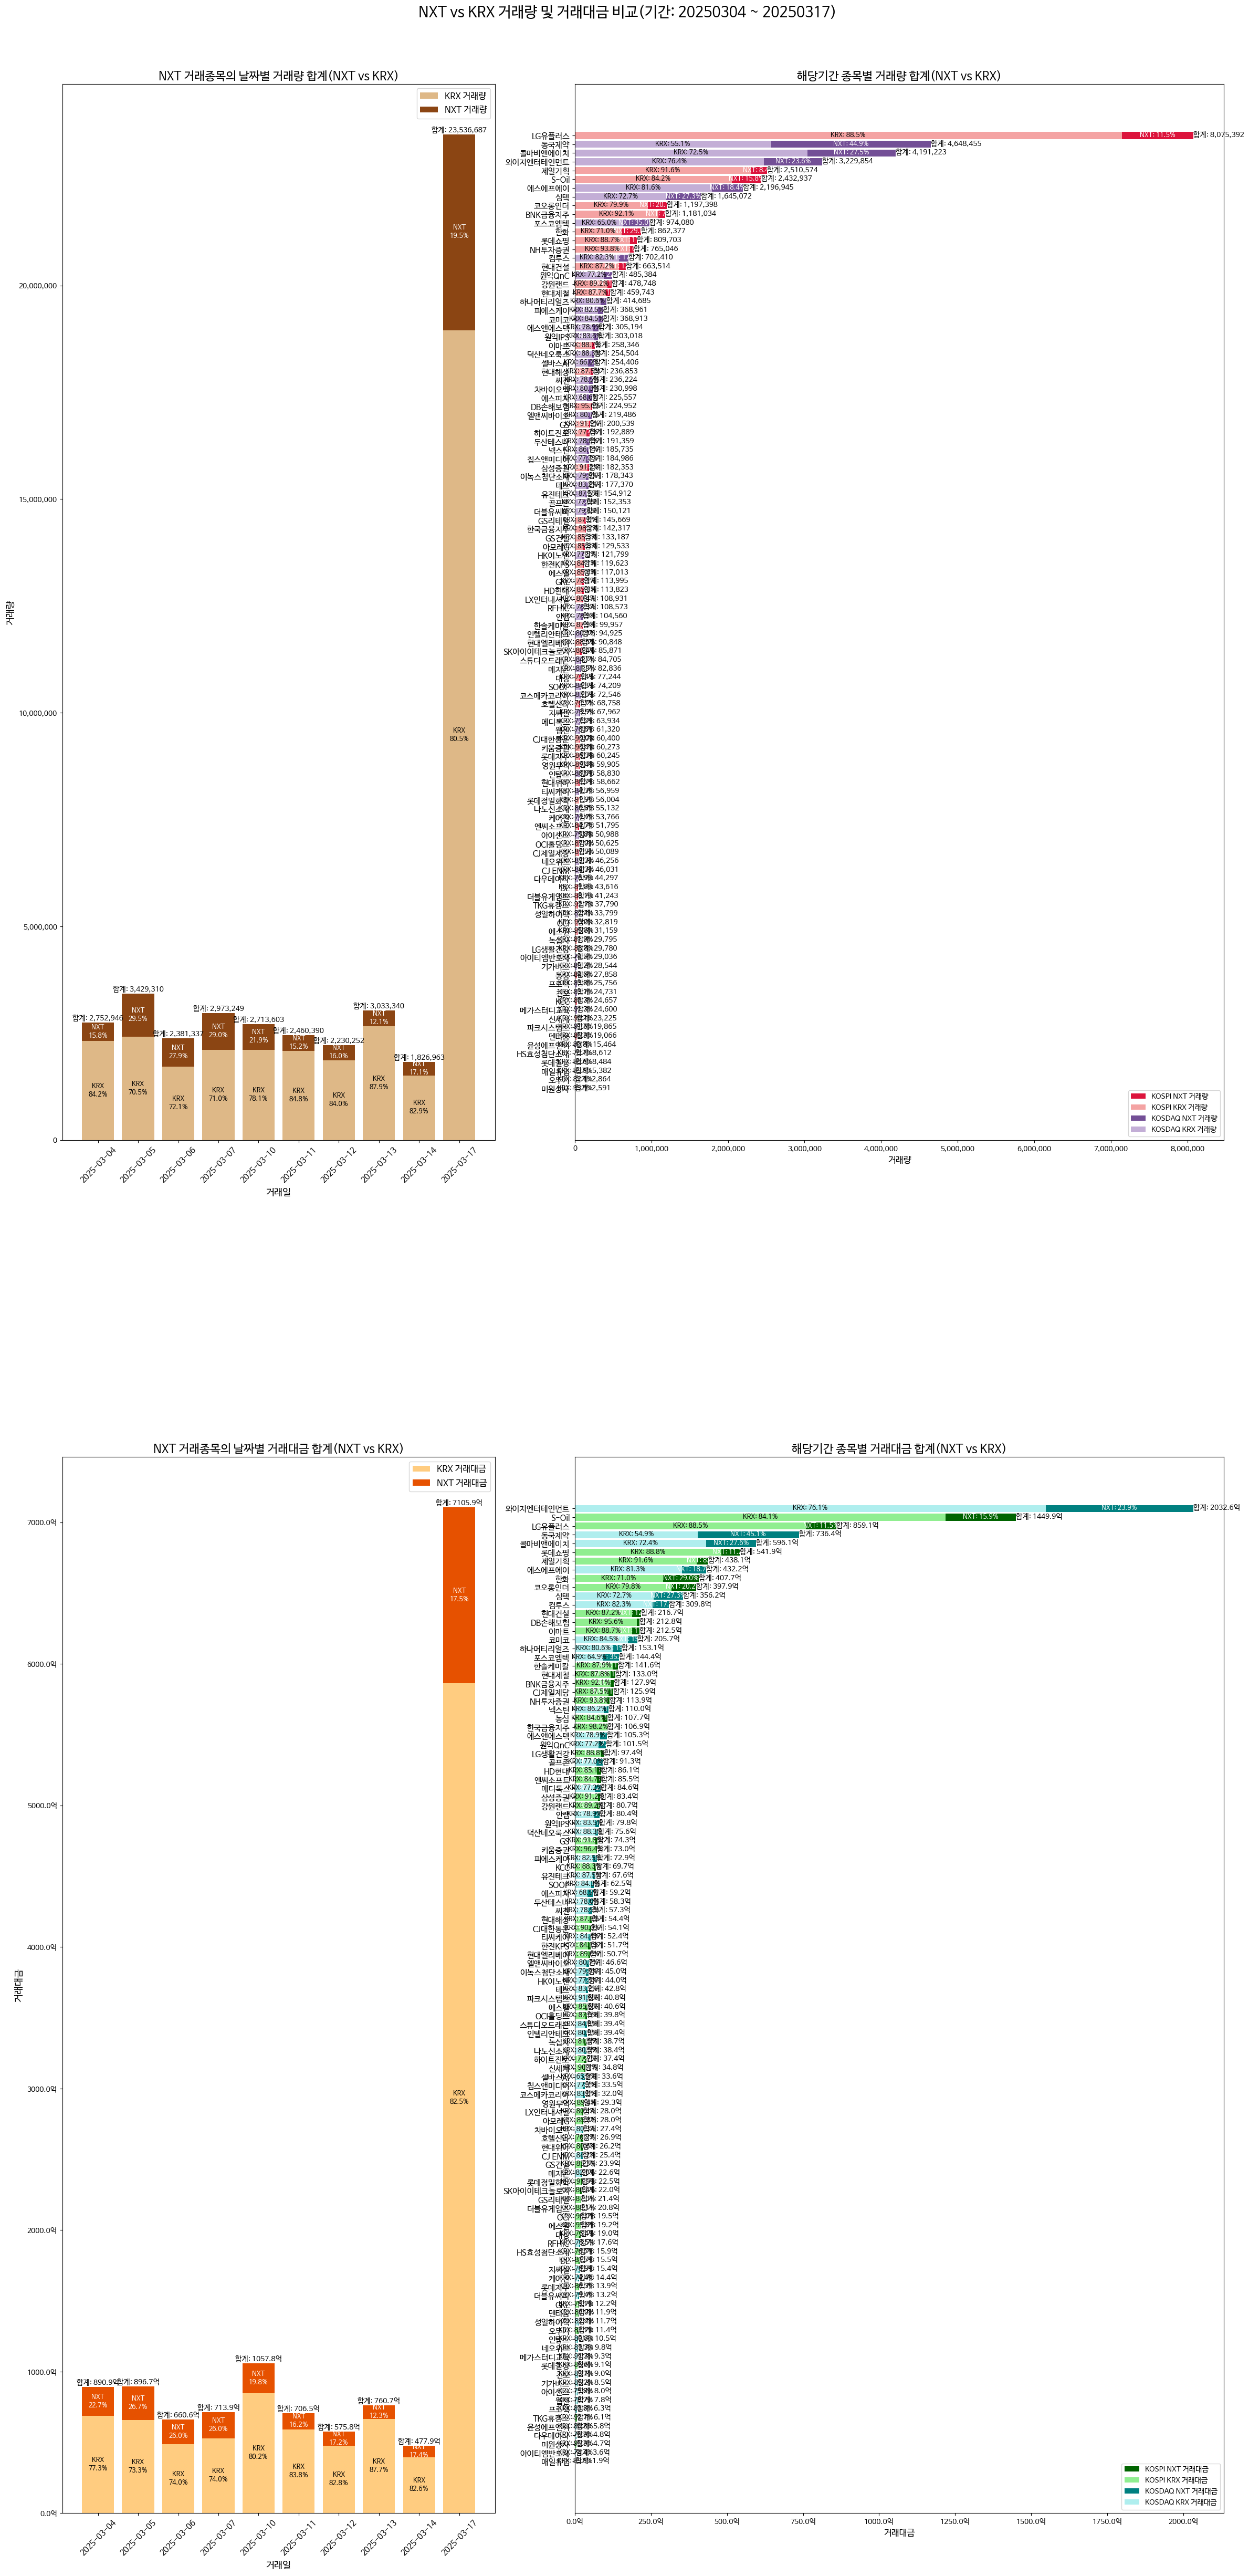

In [9]:
# 4개의 서브플롯을 포함하는 하나의 figure 생성
fig, axes = plt.subplots(2, 2, figsize=(24, 50), gridspec_kw={'width_ratios': [1, 1.5]})
ax1, ax2 = axes[0]  # 상단 (거래량)
ax3, ax4 = axes[1]  # 하단 (거래대금)

# ============= 좌상단 그래프: 날짜별 거래량 =============
# 날짜 형식 변환
df_bydate['수집일'] = pd.to_datetime(df_bydate['수집일'], format='%Y%m%d')

# 날짜 기준으로 정렬
df_bydate_sorted = df_bydate.sort_values('수집일')

# X축 위치 설정
x = np.arange(len(df_bydate_sorted))

# 스택 바 차트 데이터 준비 (거래량)
nxt_volumes = df_bydate_sorted['NXT거래량'].values
krx_volumes = df_bydate_sorted['KRX거래량'].values
total_volumes = nxt_volumes+krx_volumes

# 스택 바 차트 그리기
bars_krx = ax1.bar(x, krx_volumes, label='KRX 거래량', color='#DEB887')
bars_nxt = ax1.bar(x, nxt_volumes, bottom=krx_volumes, label='NXT 거래량', color='#8B4513')

# 데이터 레이블 추가 (백분율)
for i, (nxt, krx, total) in enumerate(zip(nxt_volumes, krx_volumes, total_volumes)):
    # 백분율 계산
    nxt_percent = (nxt / total) * 100
    krx_percent = (krx / total) * 100

    # NXT 레이블
    ax1.text(i, krx + nxt/2, f'NXT\n{nxt_percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # KRX 레이블
    ax1.text(i, krx/2, f'KRX\n{krx_percent:.1f}%', ha='center', va='center', fontsize=9)

    # 전체 합계 레이블
    ax1.text(i, total, f'합계: {int(total):,}', ha='center', va='bottom', fontsize=10)

# X축 및 Y축 레이블 설정
ax1.set_xlabel('거래일', fontsize=13)
ax1.set_ylabel('거래량', fontsize=13)
ax1.set_title('NXT 거래종목의 날짜별 거래량 합계(NXT vs KRX)', fontsize=16)

# X축 눈금 설정
ax1.set_xticks(x)
ax1.set_xticklabels(df_bydate_sorted['수집일'].dt.strftime('%Y-%m-%d'), fontsize=11, rotation=45)

# Y축 단위 설정 (천 단위 구분자)
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# 범례 추가
ax1.legend(fontsize=12)

# ============= 우상단 그래프: 종목별 거래량 =============
# 전체 거래대금 기준 내림차순 정렬
df_bystock['합계거래량'] = df_bystock['KRX거래량']+df_bystock['NXT거래량']

# 전체 거래량 기준 내림차순 정렬
df_bystock_sorted_vol = df_bystock.sort_values(by='합계거래량', ascending=False)

# Y축 위치 설정
y = np.arange(len(df_bystock_sorted_vol))

# 스택 바 차트 데이터 준비
nxt_volumes = df_bystock_sorted_vol['NXT거래량'].values
krx_volumes = df_bystock_sorted_vol['KRX거래량'].values
total_volumes = nxt_volumes+krx_volumes

# 색상 지정
nxt_colors = np.where(df_bystock_sorted_vol['시장구분'] == 'KOSPI', 'crimson', '#734F96')
krx_colors = np.where(df_bystock_sorted_vol['시장구분'] == 'KOSPI', '#F4A3A3', '#C3AED6')

# 스택 가로 막대 그래프 그리기
bars_krx = ax2.barh(y, krx_volumes, label='KRX 거래량', color=krx_colors)
bars_nxt = ax2.barh(y, nxt_volumes, left=krx_volumes, label='NXT 거래량', color=nxt_colors)

# 데이터 레이블 추가 (백분율)
for i, (nxt, krx, total) in enumerate(zip(nxt_volumes, krx_volumes, total_volumes)):
    # 백분율 계산
    nxt_percent = (nxt / total) * 100
    krx_percent = (krx / total) * 100

    # NXT 레이블
    if nxt > total * 0.05:  # NXT 부분이 충분히 큰 경우에만 표시
        ax2.text(krx + nxt/2, i, f'NXT: {nxt_percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # KRX 레이블
    if krx > total * 0.05:  # KRX 부분이 충분히 큰 경우에만 표시
        ax2.text(krx/2, i, f'KRX: {krx_percent:.1f}%', ha='center', va='center', fontsize=9)

    # 전체 합계 레이블
    ax2.text(total, i, f'합계: {int(total):,}', ha='left', va='center', fontsize=10)

# Y축 레이블 설정
ax2.set_yticks(y)
ax2.set_yticklabels(df_bystock_sorted_vol['종목명'], fontsize=11)

# X축 및 Y축 레이블 설정
ax2.set_xlabel('거래량', fontsize=12)
ax2.set_title('해당기간 종목별 거래량 합계(NXT vs KRX)', fontsize=16)

# X축 단위 설정 (천 단위 구분자)
ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Y축 반전
ax2.invert_yaxis()

# 범례 추가
vol_leg_handles = [
    plt.Rectangle((0,0),1,1,fc="crimson", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#F4A3A3", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#734F96", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#C3AED6", edgecolor='none')
]

ax2.legend(vol_leg_handles,
           ['KOSPI NXT 거래량', 'KOSPI KRX 거래량',
            'KOSDAQ NXT 거래량', 'KOSDAQ KRX 거래량'],
           fontsize=10, loc='lower right')

# ============= 좌하단 그래프: 날짜별 거래대금 =============
# 스택 바 차트 데이터 준비 (거래대금)
nxt_values = df_bydate_sorted['NXT거래대금'].values
krx_values = df_bydate_sorted['KRX거래대금'].values
total_values = nxt_values+krx_values

# 스택 바 차트 그리기
bars_krx = ax3.bar(x, krx_values, label='KRX 거래대금', color='#FFCC80')  # 연한 주황색
bars_nxt = ax3.bar(x, nxt_values, bottom=krx_values, label='NXT 거래대금', color='#E65100')  # 짙은 주황색

# 데이터 레이블 추가 (백분율)
for i, (nxt, krx, total) in enumerate(zip(nxt_values, krx_values, total_values)):
    # 백분율 계산
    nxt_percent = (nxt / total) * 100
    krx_percent = (krx / total) * 100

    # NXT 레이블
    ax3.text(i, krx + nxt/2, f'NXT\n{nxt_percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # KRX 레이블
    ax3.text(i, krx/2, f'KRX\n{krx_percent:.1f}%', ha='center', va='center', fontsize=9)

    # 전체 합계 레이블 (억원)
    ax3.text(i, total, f'합계: {total/100000000:.1f}억', ha='center', va='bottom', fontsize=10)

# X축 및 Y축 레이블 설정
ax3.set_xlabel('거래일', fontsize=13)
ax3.set_ylabel('거래대금', fontsize=13)
ax3.set_title('NXT 거래종목의 날짜별 거래대금 합계(NXT vs KRX)', fontsize=16)

# X축 눈금 설정
ax3.set_xticks(x)
ax3.set_xticklabels(df_bydate_sorted['수집일'].dt.strftime('%Y-%m-%d'), fontsize=11, rotation=45)

# Y축 단위 설정 (억원)
ax3.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1f}억".format(x/100000000)))

# 범례 추가
ax3.legend(fontsize=12)

# ============= 우하단 그래프: 종목별 거래대금 =============
# 전체 거래대금 기준 내림차순 정렬
df_bystock['합계거래대금'] = df_bystock['KRX거래대금']+df_bystock['NXT거래대금']

# 전체 거래대금 기준 내림차순 정렬
df_bystock_sorted_val = df_bystock.sort_values(by='합계거래대금', ascending=False)

# Y축 위치 설정
y = np.arange(len(df_bystock_sorted_val))

# 스택 바 차트 데이터 준비
nxt_values = df_bystock_sorted_val['NXT거래대금'].values
krx_values = df_bystock_sorted_val['KRX거래대금'].values
total_values = nxt_values+krx_values

# 색상 지정
nxt_colors = np.where(df_bystock_sorted_val['시장구분'] == 'KOSPI', '#006400', '#008080')  # 진한 녹색, 진한 청록색
krx_colors = np.where(df_bystock_sorted_val['시장구분'] == 'KOSPI', '#90EE90', '#AFEEEE')  # 연한 녹색, 연한 청록색

# 스택 가로 막대 그래프 그리기
bars_krx = ax4.barh(y, krx_values, label='KRX 거래대금', color=krx_colors)
bars_nxt = ax4.barh(y, nxt_values, left=krx_values, label='NXT 거래대금', color=nxt_colors)

# 데이터 레이블 추가 (백분율)
for i, (nxt, krx, total) in enumerate(zip(nxt_values, krx_values, total_values)):
    # 백분율 계산
    nxt_percent = (nxt / total) * 100
    krx_percent = (krx / total) * 100

    # NXT 레이블
    if nxt > total * 0.05:  # NXT 부분이 충분히 큰 경우에만 표시
        ax4.text(krx + nxt/2, i, f'NXT: {nxt_percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # KRX 레이블
    if krx > total * 0.05:  # KRX 부분이 충분히 큰 경우에만 표시
        ax4.text(krx/2, i, f'KRX: {krx_percent:.1f}%', ha='center', va='center', fontsize=9)

    # 전체 합계 레이블 (억원)
    ax4.text(total, i, f'합계: {total/100000000:.1f}억', ha='left', va='center', fontsize=10)

# Y축 레이블 설정
ax4.set_yticks(y)
ax4.set_yticklabels(df_bystock_sorted_val['종목명'], fontsize=11)

# X축 및 Y축 레이블 설정
ax4.set_xlabel('거래대금', fontsize=12)
ax4.set_title('해당기간 종목별 거래대금 합계(NXT vs KRX)', fontsize=16)

# X축 단위 설정 (억원)
ax4.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1f}억".format(x/100000000)))

# Y축 반전
ax4.invert_yaxis()

# 범례 추가
val_leg_handles = [
    plt.Rectangle((0,0),1,1,fc="#006400", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#90EE90", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#008080", edgecolor='none'),
    plt.Rectangle((0,0),1,1,fc="#AFEEEE", edgecolor='none')
]

ax4.legend(val_leg_handles,
           ['KOSPI NXT 거래대금', 'KOSPI KRX 거래대금',
            'KOSDAQ NXT 거래대금', 'KOSDAQ KRX 거래대금'],
           fontsize=10, loc='lower right')

# 전체 그림 제목 (상단에 표시)
plt.suptitle(f'NXT vs KRX 거래량 및 거래대금 비교(기간: {period})', fontsize=20)

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3)  # 상단 여백 및 그래프 간 간격 조정

plt.show()


[(링크)[그래픽] 종목별 한국거래소 대비 넥스트레이드 거래량 비중](https://www.yna.co.kr/view/GYH20250304001100044?input=1363m)

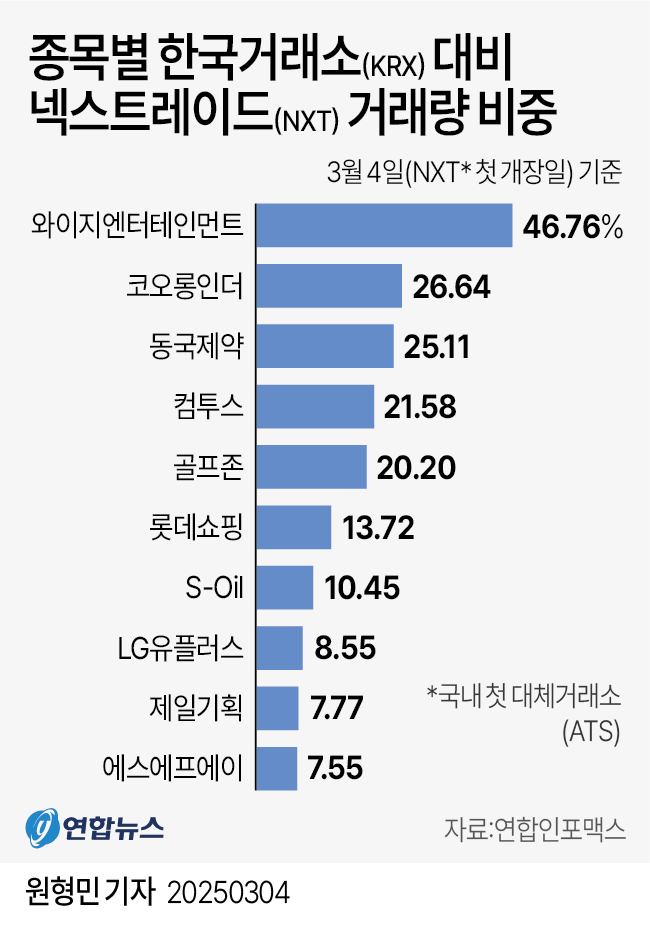